In [1]:
import re
import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit

%matplotlib inline

from collections import Counter, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pylab, gridspec, pyplot as plt
from IPython.display import Image
import urllib


from sklearn.metrics import accuracy_score
from sklearn import metrics, neighbors, dummy, preprocessing, svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder

from tqdm import tqdm_notebook as tqdm

import matplotlib
%matplotlib inline

# Reading data

In [20]:
train = pd.read_csv('train.csv')
train.drop('id', axis = 1, inplace = True)
test = pd.read_csv('test.csv')#.drop(['id', axis=1)

train.shape, test.shape

((900, 217), (9050, 217))

In [21]:
train.head()

,label,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat207,feat208,feat209,feat210,feat211,feat212,feat213,feat214,feat215,feat216
0,1,7,0,3,0,2,3,0,6,0,...,3,4,2,2,0,13,0,11,1,3
1,1,0,11,0,0,10,1,0,0,4,...,0,2,0,0,2,8,1,13,0,4
2,0,9,0,3,0,1,3,0,4,0,...,48,11,2,0,0,4,0,2,0,0
3,0,0,9,3,2,25,0,4,0,0,...,1,14,1,0,0,0,3,0,17,1
4,0,0,0,0,0,2,5,0,0,0,...,3,12,0,3,0,4,0,24,4,0


In [22]:
test.head()

,id,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat207,feat208,feat209,feat210,feat211,feat212,feat213,feat214,feat215,feat216
0,1,4,2,2,0,4,2,1,2,1,...,4,5,3,1,0,7,1,6,2,3
1,2,3,3,0,0,1,2,0,9,3,...,8,1,0,0,1,21,0,27,2,0
2,3,0,0,0,2,2,8,0,1,0,...,3,23,0,0,0,1,0,5,1,1
3,4,0,0,0,0,0,0,0,7,0,...,9,4,0,0,0,14,0,18,1,3
4,5,1,2,3,0,2,0,0,13,0,...,2,4,0,2,0,20,0,17,1,7


In [23]:
from sklearn.preprocessing import StandardScaler

# place your code here
scaler = StandardScaler(with_mean=True, with_std=True)
train_scaled = pd.DataFrame(scaler.fit_transform(train))
test_scaled = pd.DataFrame(scaler.fit_transform(test))

In [24]:
X_train = train_scaled.drop([0], axis=1)
y_train = train['label']
X_test  = test_scaled.drop([0], axis=1)
X_train.shape, y_train.shape, X_test.shape

((900, 216), (900,), (9050, 216))

In [25]:
X_test.head()

,1,2,3,4,5,6,7,8,9,10,...,207,208,209,210,211,212,213,214,215,216
0,0.665312,-0.314477,-0.075507,-0.655047,0.076977,-0.364467,0.022664,-0.446682,-0.267789,-0.582498,...,-0.058028,-0.225863,0.689578,-0.115842,-0.501385,-0.209230,0.029550,-0.456174,-0.352862,-0.271161
1,0.346686,-0.152707,-0.678363,-0.655047,-0.423124,-0.364467,-0.533177,0.910439,0.292620,-0.104795,...,0.666819,-0.631148,-0.528433,-0.377410,0.128303,1.034935,-0.437974,1.014744,-0.352862,-0.680118
2,-0.609192,-0.638017,-0.678363,1.140011,-0.256423,0.767069,-0.533177,-0.640557,-0.547993,0.850610,...,-0.239240,1.597922,-0.528433,-0.377410,-0.501385,-0.742443,-0.437974,-0.526218,-0.539513,-0.543799
3,-0.609192,-0.638017,-0.678363,-0.655047,-0.589824,-0.741646,-0.533177,0.522690,-0.547993,0.850610,...,0.848031,-0.327184,-0.528433,-0.377410,-0.501385,0.412852,-0.437974,0.384350,-0.539513,-0.271161
4,-0.290566,-0.314477,0.225921,-0.655047,-0.256423,-0.741646,-0.533177,1.685937,-0.547993,-0.104795,...,-0.420451,-0.327184,-0.528433,0.145727,-0.501385,0.946066,-0.437974,0.314307,-0.539513,0.274114


# Huge grid search

In [26]:
cv_strategy = ShuffleSplit(n_splits=10, test_size=0.2, random_state=33)

### SGD Classifier

In [120]:
scores = []
coefs = []
for maxit in tqdm([10, 50, 100, 300, 500, 1000, 2000, 3000, 4000, 5000, 7000, 10000]):
    for alpha in tqdm([0.05, 0.1, 0.2, 0.3, 0.4, 0.5]):
        estimator = SGDClassifier(max_iter=maxit, tol=0.1, penalty='l1', alpha=alpha)
        scoring = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=cv_strategy)
        print('maxit: ', maxit, 'alpha: ', alpha, 'score: ', scoring.mean())

A Jupyter Widget

A Jupyter Widget

maxit:  10 alpha:  0.05 score:  0.85805924309
maxit:  10 alpha:  0.1 score:  0.83304738382
maxit:  10 alpha:  0.2 score:  0.788690292107
maxit:  10 alpha:  0.3 score:  0.615199160952
maxit:  10 alpha:  0.4 score:  0.596690417494
maxit:  10 alpha:  0.5 score:  0.54929725915


A Jupyter Widget

maxit:  50 alpha:  0.05 score:  0.874999116355
maxit:  50 alpha:  0.1 score:  0.844618124081
maxit:  50 alpha:  0.2 score:  0.763305025586
maxit:  50 alpha:  0.3 score:  0.575924934596
maxit:  50 alpha:  0.4 score:  0.523787715517
maxit:  50 alpha:  0.5 score:  0.5372089146


A Jupyter Widget

maxit:  100 alpha:  0.05 score:  0.854330165797
maxit:  100 alpha:  0.1 score:  0.825418028841
maxit:  100 alpha:  0.2 score:  0.759162343564
maxit:  100 alpha:  0.3 score:  0.615166346862
maxit:  100 alpha:  0.4 score:  0.525804186627
maxit:  100 alpha:  0.5 score:  0.5


A Jupyter Widget

maxit:  300 alpha:  0.05 score:  0.862406223605
maxit:  300 alpha:  0.1 score:  0.83513489605
maxit:  300 alpha:  0.2 score:  0.743097791129
maxit:  300 alpha:  0.3 score:  0.610746205363
maxit:  300 alpha:  0.4 score:  0.5
maxit:  300 alpha:  0.5 score:  0.511314611315


A Jupyter Widget

maxit:  500 alpha:  0.05 score:  0.863473778229
maxit:  500 alpha:  0.1 score:  0.809241804396
maxit:  500 alpha:  0.2 score:  0.702664415517
maxit:  500 alpha:  0.3 score:  0.587433105235
maxit:  500 alpha:  0.4 score:  0.530436847104
maxit:  500 alpha:  0.5 score:  0.489887377549


A Jupyter Widget

maxit:  1000 alpha:  0.05 score:  0.859508193411
maxit:  1000 alpha:  0.1 score:  0.852785381401
maxit:  1000 alpha:  0.2 score:  0.805395819439
maxit:  1000 alpha:  0.3 score:  0.608940724978
maxit:  1000 alpha:  0.4 score:  0.521469271469
maxit:  1000 alpha:  0.5 score:  0.489998694347


A Jupyter Widget

maxit:  2000 alpha:  0.05 score:  0.846436695257
maxit:  2000 alpha:  0.1 score:  0.84342011113
maxit:  2000 alpha:  0.2 score:  0.790846767057
maxit:  2000 alpha:  0.3 score:  0.632263733472
maxit:  2000 alpha:  0.4 score:  0.50027649177
maxit:  2000 alpha:  0.5 score:  0.539270700899


A Jupyter Widget

maxit:  3000 alpha:  0.05 score:  0.870197233646
maxit:  3000 alpha:  0.1 score:  0.837687434611
maxit:  3000 alpha:  0.2 score:  0.71153318938
maxit:  3000 alpha:  0.3 score:  0.521671791
maxit:  3000 alpha:  0.4 score:  0.509607628434
maxit:  3000 alpha:  0.5 score:  0.511862041467


A Jupyter Widget

maxit:  4000 alpha:  0.05 score:  0.848851884122
maxit:  4000 alpha:  0.1 score:  0.844996212409
maxit:  4000 alpha:  0.2 score:  0.769683262421
maxit:  4000 alpha:  0.3 score:  0.561637448885
maxit:  4000 alpha:  0.4 score:  0.5
maxit:  4000 alpha:  0.5 score:  0.51997813786


A Jupyter Widget

maxit:  5000 alpha:  0.05 score:  0.863252508879
maxit:  5000 alpha:  0.1 score:  0.852930162128
maxit:  5000 alpha:  0.2 score:  0.779037489236
maxit:  5000 alpha:  0.3 score:  0.599280572718
maxit:  5000 alpha:  0.4 score:  0.559170688567
maxit:  5000 alpha:  0.5 score:  0.515056777965


A Jupyter Widget

maxit:  7000 alpha:  0.05 score:  0.845446524527
maxit:  7000 alpha:  0.1 score:  0.825421445788
maxit:  7000 alpha:  0.2 score:  0.801052399499
maxit:  7000 alpha:  0.3 score:  0.600616917029
maxit:  7000 alpha:  0.4 score:  0.5
maxit:  7000 alpha:  0.5 score:  0.501424501425


A Jupyter Widget

maxit:  10000 alpha:  0.05 score:  0.868914345853
maxit:  10000 alpha:  0.1 score:  0.844122854806
maxit:  10000 alpha:  0.2 score:  0.784962638235
maxit:  10000 alpha:  0.3 score:  0.574926097726
maxit:  10000 alpha:  0.4 score:  0.530273817087
maxit:  10000 alpha:  0.5 score:  0.547852634695



## SVC

In [27]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']:
    for C in tqdm([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]):
#         for gamma in (np.linspace(0.01, 3, 10)):
        estimator = SVC(kernel=kernel, C=C, gamma=2)
        scoring = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=cv_strategy)
        print('score', scoring.mean(), 'kernel:', kernel, 'C:', C)

A Jupyter Widget

score 0.913362559316 kernel: linear C: 0.05
score 0.913764917102 kernel: linear C: 0.1



KeyboardInterrupt: 

# Fit methods

In [9]:
estimators = [
    SGDClassifier(max_iter=5000, tol=0.1, penalty='l1', alpha=0.1),
    SVC(kernel='rbf', C = 0.1, gamma=2),
    LinearSVC(penalty = 'l2', dual=False), 
    LogisticRegression(penalty='l1', C=0.2),
]

In [10]:

for estimator in estimators:
    %time scoring = cross_val_score(estimator, X_train, Y_train, scoring='roc_auc', cv=cv_strategy)
    print ('%s %.3lf' % (str(estimator).replace('(',' ').split()[0], scoring.mean()), '%.4lf' % scoring.std())

CPU times: user 1.72 s, sys: 60 ms, total: 1.78 s
Wall time: 1.65 s
SGDClassifier 0.869 0.0295
CPU times: user 2.58 s, sys: 8 ms, total: 2.59 s
Wall time: 2.39 s
SVC 0.877 0.0171
CPU times: user 9.41 s, sys: 72 ms, total: 9.48 s
Wall time: 7.73 s
LinearSVC 0.913 0.0147
CPU times: user 2.58 s, sys: 84 ms, total: 2.67 s
Wall time: 1.34 s
LogisticRegression 0.923 0.0189


In [60]:
scores = []
coefs = []
for coef in tqdm(np.arange(0.05, 1.0, 0.01)):
    
#     print('coef:', coef)
    estimator = LogisticRegression(penalty='l1', C=coef)
    scoring = cross_val_score(estimator, X_train, Y_train, scoring='roc_auc', cv=cv_strategy)
#     print ('%s %.3lf' % (str(estimator).replace('(',' ').split()[0], scoring.mean()), '%.4lf' % scoring.std())
    coefs.append(coef)
    scores.append(scoring.mean())
    

A Jupyter Widget

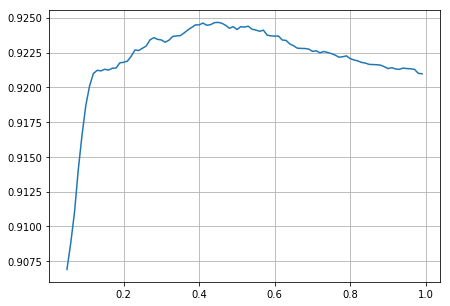

In [116]:
plt.figure(figsize=(7, 5))
plt.plot(coefs, scores)
plt.grid()
plt.show()

# Final classifier

In [70]:
estimator = LogisticRegression(penalty='l1', C=0.45, class_weight='balanced') #benchmark_1
estimator.fit(X_train, Y_train)

LogisticRegression(C=0.45, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [28]:
estimator = SVC(kernel='poly', C=0.1, gamma=2)
estimator.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(estimator.coef_[0])),sorted(np.abs(estimator.coef_[0])))
plt.grid()
plt.show()

AttributeError: coef_ is only available when using a linear kernel

# Test data estimation

In [30]:
test_predict=estimator.predict(X_test)

ans = pd.DataFrame()
ans['id'] = test['id']
ans['label'] = test_predict
ans.to_csv('benchmark_2.csv', sep = ',', index=False)